### LIBS & CONNECTOR

In [167]:
from IPython.display import clear_output

In [1]:
import pandas as pd
import numpy as np
import sqlalchemy as sa
import mysql.connector
import getpass

In [2]:
import math
import numpy as np
from gensim.models import Word2Vec
from gensim.test.utils import common_texts
from nltk import word_tokenize
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings("ignore")

In [255]:
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_distances
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from hdbscan import HDBSCAN

In [254]:
HOST = 'localhost'
USER = 'root'
DATABASE = 'goodreads'
PASSWORD = getpass.getpass(f'Enter password for {USER}: ')

In [7]:
def getconn():
    conn = mysql.connector.connect(
        host=HOST,
        user=USER,
        password=PASSWORD,
        database=DATABASE
    )
    return conn

pool = sa.create_engine(
    "mysql+mysqlconnector://",
    creator=getconn,
)

with pool.connect() as db_conn:
    results = db_conn.execute(sa.text("SELECT NOW()")).fetchone()
    print("Current time: ", results[0])

Current time:  2023-06-02 15:04:14


### DATA

In [8]:
model = Word2Vec(sentences=common_texts, vector_size=100, window=5, min_count=1, workers=4)

In [9]:
query = sa.text(
    "SELECT * FROM processed_description;"
)
df = pd.read_sql_query(query, con=pool.connect())

In [11]:
user_id_query = sa.text(
    "SELECT DISTINCT(user_id) FROM new_ratings_;"
)
user_id_df = pd.read_sql_query(user_id_query, con=pool.connect())
user_id_list = user_id_df.user_id.tolist()
user_id_list[:5]

['1', '10', '100', '1000', '10000']

In [81]:
query = sa.text(
    "SELECT user_id, goodreads_book_id, (rating * 0.2) as rating from new_ratings_;"
)

user_ratings = pd.read_sql_query(query, con=pool.connect())

### WORD2VEC

In [12]:
sample = df.processed_descr.tolist()
sample_len = len(sample)
sample_texts = [word_tokenize(sent) for sent in sample]

In [13]:
model_3 = Word2Vec(sentences=sample_texts, vector_size=300, window=5, min_count=1, workers=4)
model_1 = Word2Vec(sentences=sample_texts, vector_size=100, window=5, min_count=1, workers=4)

In [14]:
sims_3 = model_3.wv.similar_by_key('survive')
sims_1 = model_1.wv.similar_by_key('survive')

In [15]:
def get_vec(texts, model, vector_size = 100):
    result_vectors = []
    for text in texts:
        sent_vector = [0]*vector_size
        for word in text:
            sent_vector += model.wv[word]
        sent_vector = [value/len(sent_vector) for value in sent_vector]
        result_vectors.append(sent_vector)
    return result_vectors

In [16]:
vectors = get_vec(sample_texts, model_1)

In [17]:
sim_matrix = cosine_similarity(vectors)

In [18]:
ids = df.goodreads_book_id.tolist()
indices = pd.Series(df.index, index=ids)

In [19]:
idx = indices[3]
sim_scores = list(enumerate(sim_matrix[idx]))
sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
sim_scores = sim_scores[1:10]
item_indices = [i[0] for i in sim_scores]

In [20]:
# query = sa.text(
#     "SELECT * FROM books WHERE goodreads_book_id = 3;"
# )
# recommends = pd.read_sql_query(query, con=pool.connect())
# items = df.iloc[item_indices].goodreads_book_id.tolist()
# for index in items:
#     query = sa.text(
#         f"SELECT * FROM books WHERE goodreads_book_id = {index};"
#     )
#     temp = pd.read_sql_query(query, con=pool.connect())
#     recommends = pd.concat([recommends, temp])
# display(recommends)

In [21]:
# vectors = get_vec(sample_texts, model_3,300)
# sim_matrix = cosine_similarity(vectors)
# ids = df.goodreads_book_id.tolist()
# indices = pd.Series(df.index, index=ids)
# idx = indices[3]
# sim_scores = list(enumerate(sim_matrix[idx]))
# sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
# sim_scores = sim_scores[1:10]
# item_indices = [i[0] for i in sim_scores]
# query = sa.text(
#     "SELECT * FROM books WHERE goodreads_book_id = 3;"
# )
# recommends = pd.read_sql_query(query, con=pool.connect())
# items = df.iloc[item_indices].goodreads_book_id.tolist()
# for index in items:
#     query = sa.text(
#         f"SELECT * FROM books WHERE goodreads_book_id = {index};"
#     )
#     temp = pd.read_sql_query(query, con=pool.connect())
#     recommends = pd.concat([recommends, temp])
# display(recommends)

### USER VEC

In [23]:
book_vec_df = pd.DataFrame(vectors, index=[str(id) for id in ids])

In [147]:
def get_user_vector(user_id):
    this_user_ratings = user_ratings.loc[user_ratings.user_id == user_id, ['rating', 'goodreads_book_id']]
    this_user_ratings.index = this_user_ratings.goodreads_book_id
    this_user_books = book_vec_df.loc[this_user_ratings.goodreads_book_id.tolist()]
    this_user_ratings.drop(columns=['goodreads_book_id'], inplace=True)
    for index, row in this_user_books.iterrows():
        rating = this_user_ratings.loc[index].rating
        this_user_books.loc[index] = row.apply(lambda x: x* rating)
    book_nums = len(this_user_books)
    this_user_vector = [col.sum() / book_nums for _, col in this_user_books.iteritems()]
    return this_user_vector

In [271]:
user_vector_df = pd.DataFrame(columns=range(0,100))
for index, user_id in enumerate(user_id_list[:1000]):
    clear_output(wait=True)
    print(index + 1, 'of 1000')
    this_user_vector_df = pd.DataFrame([get_user_vector(user_id)], columns=range(0,100), index=[user_id])
    user_vector_df = pd.concat([user_vector_df, this_user_vector_df])
# user_vector_df.tail()

1000 of 1000


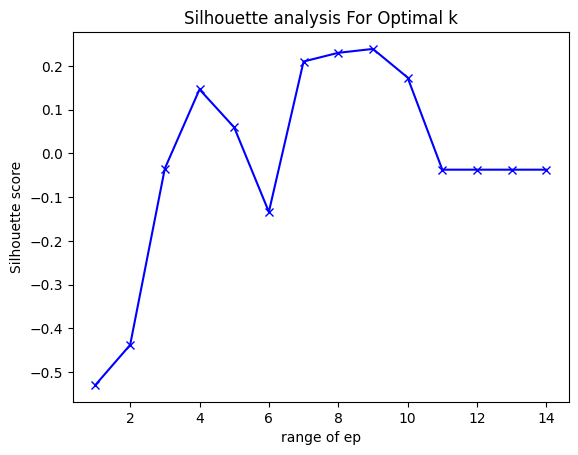

In [275]:
range_ep = range(1, 15)
n_clusters = []
silhouette_avg = []
for ep in range_ep:
    cluster = DBSCAN(eps=ep*0.0001, min_samples=3, metric='cosine', n_jobs=4)
    cluster.fit(user_vector_df)
    cluster_labels = cluster.labels_
    n_clusters.append(max(cluster_labels))
    silhouette_avg.append(silhouette_score(user_vector_df, cluster_labels))
plt.plot(range_ep, silhouette_avg, 'bx-')
plt.xlabel('range of ep')
plt.ylabel('Silhouette score')
plt.title('Silhouette analysis For Optimal k')
plt.show()


In [295]:
import pickle

size_estimate = len(pickle.dumps(user_vector_df))

In [301]:
with open('./user_vector.csv', 'wb') as pickle_file:
    pickle.dump(user_vector_df.to_csv(), pickle_file)


In [294]:
cluster = HDBSCAN(min_cluster_size=6)
max(cluster.fit_predict(user_vector_df))

1

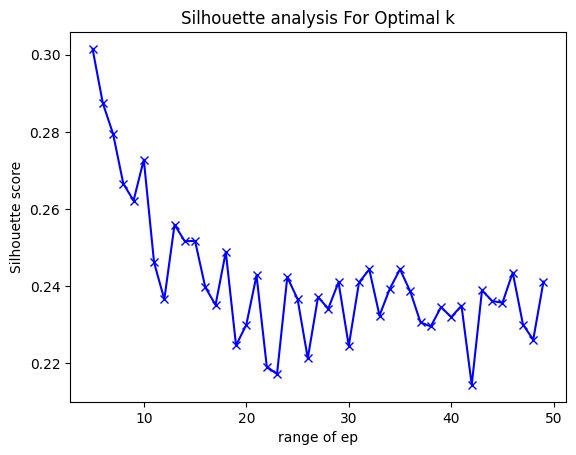

In [231]:
# range_of_n_clusters = range(5, 50)
# silhouette_avg = []
# for n_cluster in range_of_n_clusters:
#     kmeans = KMeans(n_clusters=n_cluster)
#     kmeans.fit(user_vector_df)
#     cluster_labels = kmeans.labels_

#     # silhouette score
#     silhouette_avg.append(silhouette_score(user_vector_df, cluster_labels))
# plt.plot(range_of_n_clusters, silhouette_avg, 'bx-')
# plt.xlabel('range of ep')
# plt.ylabel('Silhouette score')
# plt.title('Silhouette analysis For Optimal k')
# plt.show()

In [232]:
silhouette_avg

[0.3014720737622319,
 0.28741741057207415,
 0.27947379516792276,
 0.26656349989442335,
 0.26218151232536174,
 0.2727763230384921,
 0.2461667866968366,
 0.23661644047266572,
 0.2559328980206761,
 0.25165641731854566,
 0.2517387839868625,
 0.23972868655480098,
 0.23515380267294994,
 0.24889337088383376,
 0.22467512647701007,
 0.23000430617369128,
 0.24278852248713945,
 0.2191586190434204,
 0.2172533818977252,
 0.24236585856238915,
 0.23671341097028717,
 0.22134445894837612,
 0.23718500054131245,
 0.23420440610806467,
 0.24104714425069404,
 0.22458692683323617,
 0.24099741395964672,
 0.24436035021420202,
 0.2324132472530592,
 0.23932616256537512,
 0.24438236523603799,
 0.23865387481595893,
 0.23063611910104964,
 0.22958285265948994,
 0.23458084462197853,
 0.23202294443594906,
 0.2349496605189202,
 0.21443795356099687,
 0.2389267224736992,
 0.23616018175694162,
 0.23573585205713798,
 0.24354306887752464,
 0.23006196467539575,
 0.22616468357937286,
 0.24119695911296568]